# Benchmarking and Profiling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/notes/benchmarking.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

In this notebook, we will write a simulator and try to identify slow and inefficient parts of the code. We perform **profiling** and **benchmarking** to check time and memory consumption of our functions. We also write **tests** to ensure that changes when optimizing code preserves its correctness. 

Our strategy is to start with simple conceptual code that works, and that would inform how we write tests. In most cases, code that causes the application to
slow down is a very small fraction of the program. By identifying these critical sections, we can focus on the parts that need the most improvement without wasting time in micro-optimization.

## Simulation

To write simulation code, we divide the code into **objects** and **physics**. The physics of the system determines the update rule for each episode as well as the configuration of the initial episode. Our objects will be particles defined in the `Particle` class. This simply stores three state variables for position and signed angular speed of the particle:

In [1]:
import os; os.chdir("./benchmarking")
from hp.particles import Particle, ParticleSimulator
from hp.utils import visualize_simulation

%load_ext autoreload
%autoreload 2

In [2]:
Particle??

Init signature: Particle(x, y, angular_vel)
Docstring:      <no docstring>
Source:        
class Particle:    
    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel
File:           ~/code/ok-transformer/docs/nb/notes/benchmarking/hp/particles.py
Type:           type
Subclasses:     

The physics of the system is encoded in the `ParticleSimulator` and an initialization function for the particles. This takes in a list of particles as well as a constant `h` which is the increment for [Euler method](https://en.wikipedia.org/wiki/Euler_method). This can be interpreted as the quantum of time for the system. The simulator defines a method `evolve(t)` which incrementally updates the position of each particle from `t = 0` to `t = s` where `s = hn` for maximal `n` such that `s ≤ t`. 

Note that same update rule is applied to all particles which makes sense by symmetry. Moreover, the rule is static in that it does not change over time. These two assumptions make up the `evolve` method. The exact update rule is defined in the `update_particle` method. For this simulation, we simply rotate all particles around the origin with a fixed radius based on its initial position and with given angular velocity at initialization:

In [3]:
ParticleSimulator??

Init signature: ParticleSimulator(particles: list[hp.particles.Particle], h=1e-05)
Docstring:      <no docstring>
Source:        
class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""
        
        n_steps = int(t / self.h)
        for _ in range(n_steps):
            for p in self.particles:
                self.update_particle(p)

    def update_particle(self, p: Particle):
        """Evolve particle with Δt = h."""

        vx = -p.y * p.ω
        vy =  p.x * p.ω
        dx = vx * self.h
        dy = vy * self.h
        p.x += dx
        p.y += dy
File:           ~/code/ok-transformer/docs/nb/notes/benchmarking/hp/particles.py
Type:           type
Subclasses:     

<br>

**Example.** The following shows the time evolution of the system of three particles with the same angular speed, incremented by 1 time units for each frame.

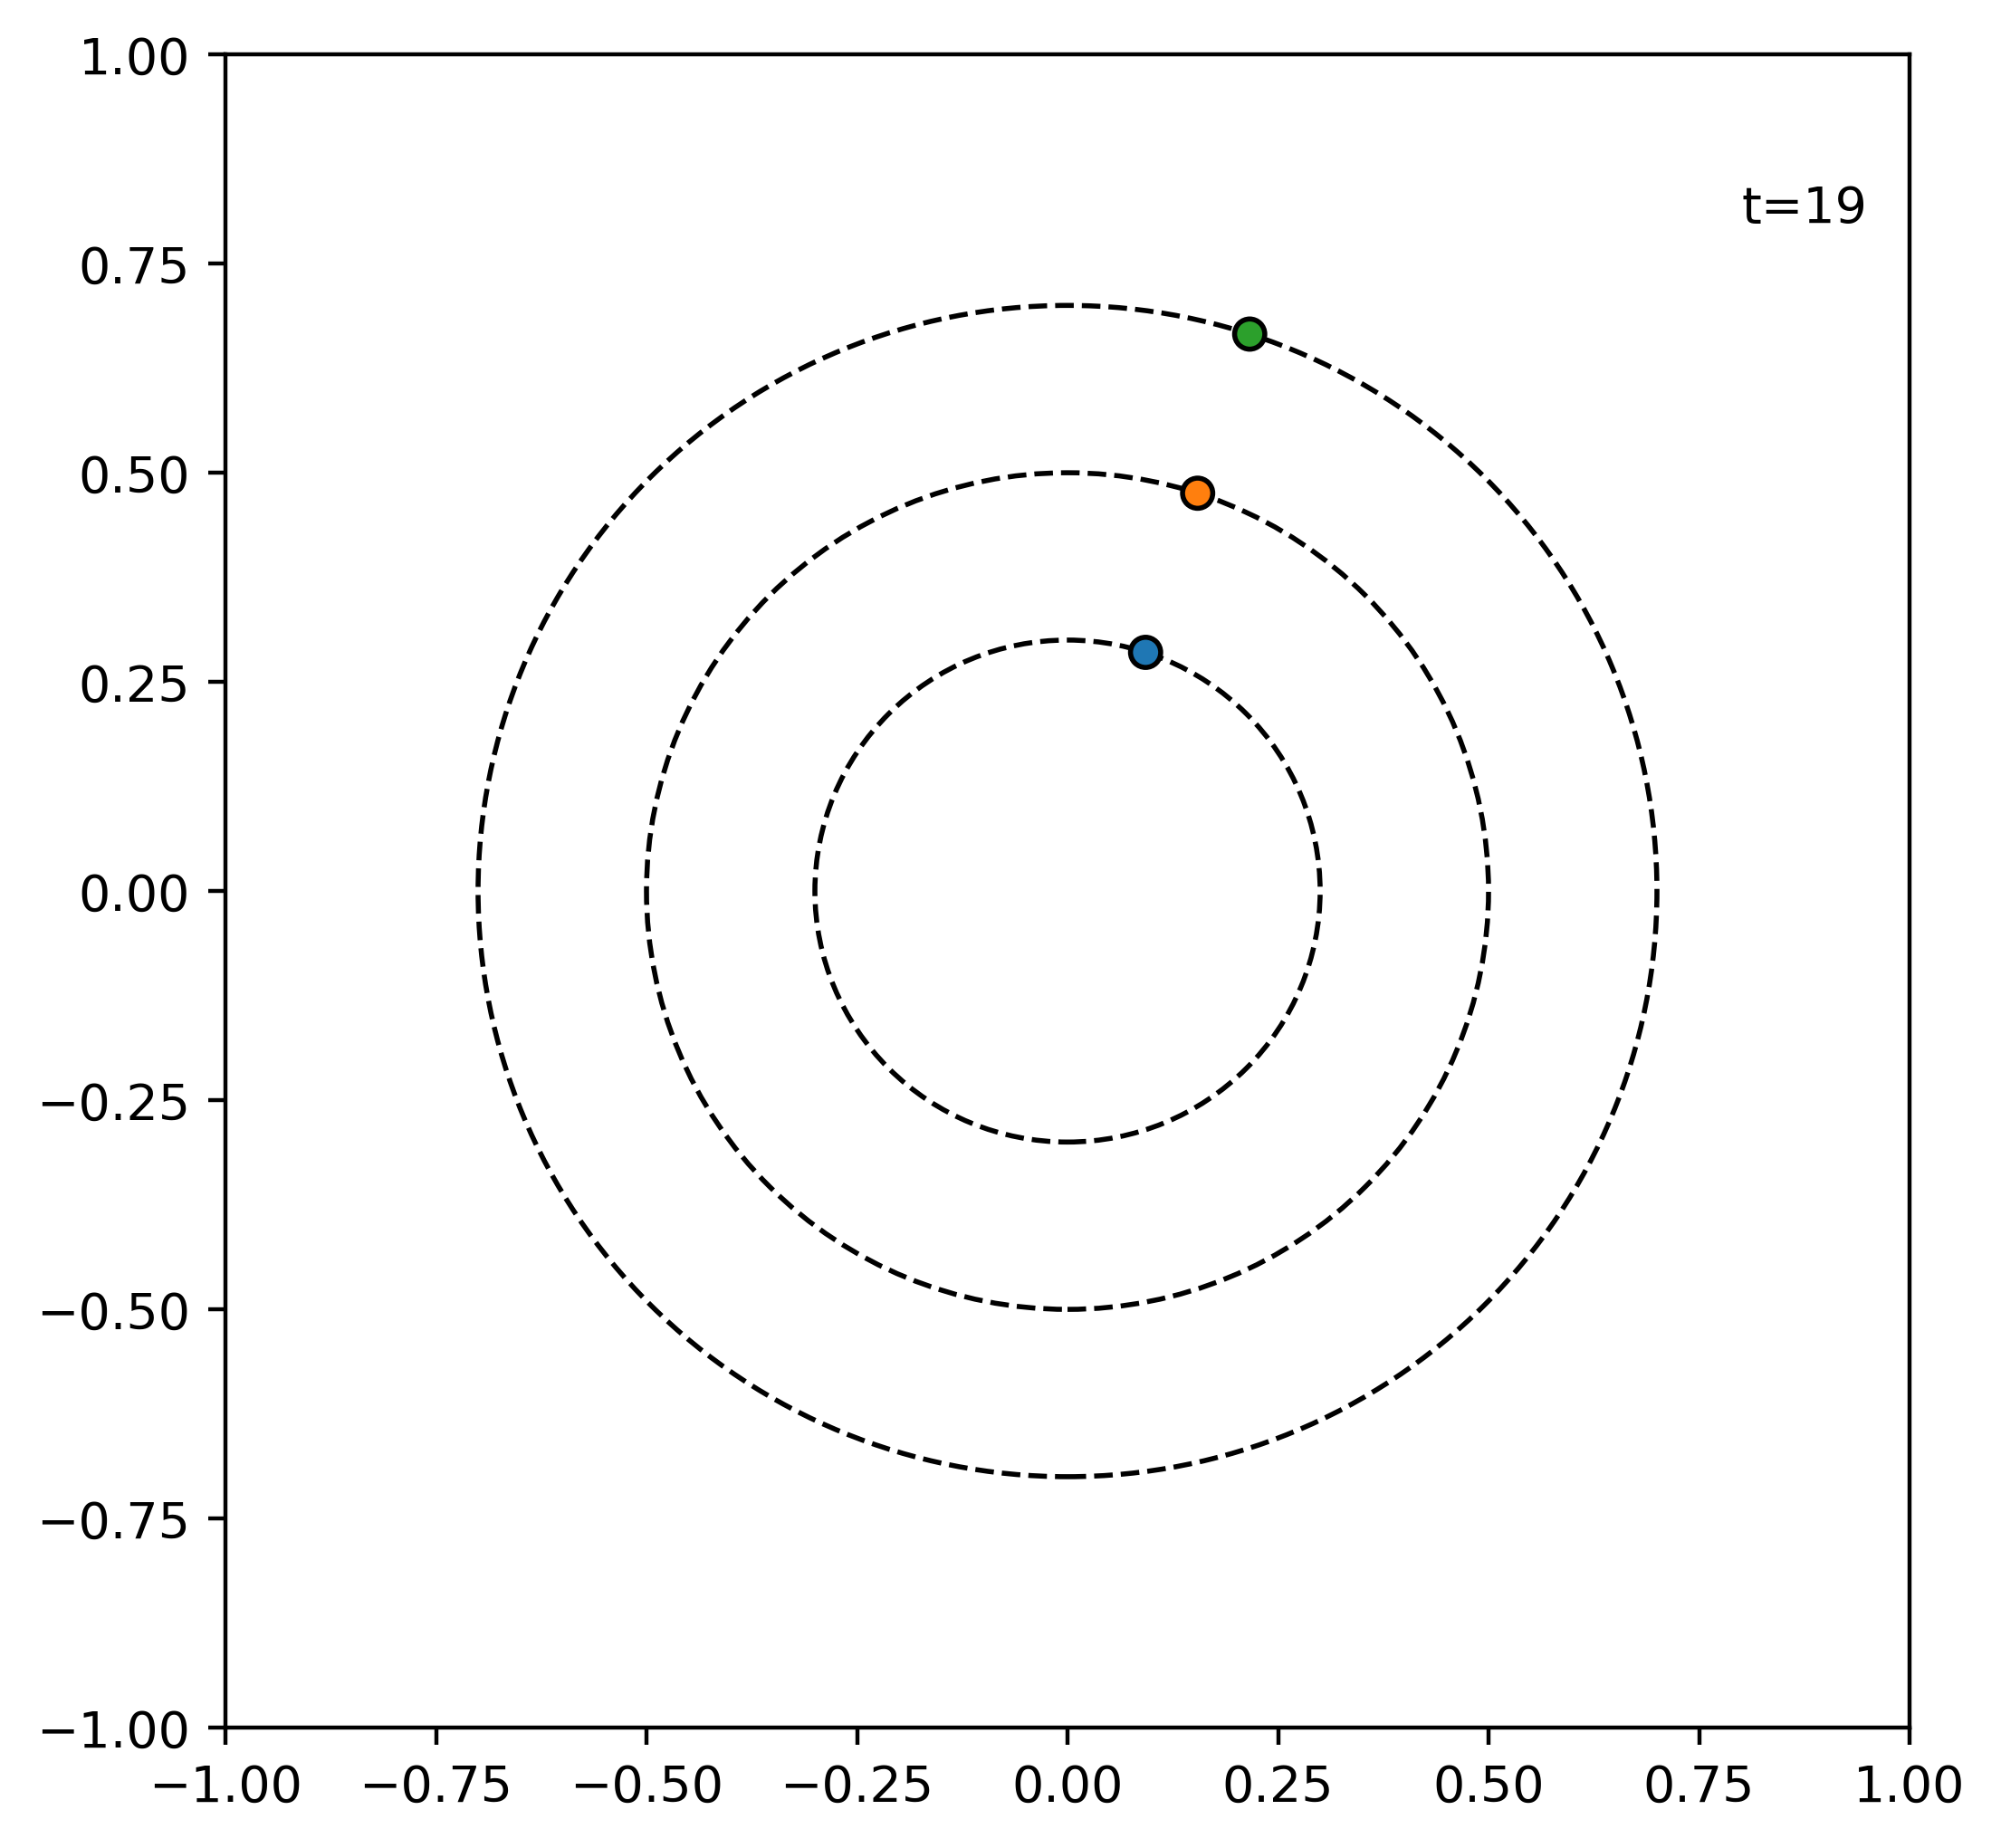

In [4]:
import math

particles = [
    Particle(0.0, 0.3, 0.10 * math.pi),
    Particle(0.0, 0.5, 0.10 * math.pi),
    Particle(0.0, 0.7, 0.10 * math.pi)
]

simulator = ParticleSimulator(particles)
visualize_simulation(simulator, timesteps=20, fps=5) # fps = no. time steps per second => 4 second GIF

```{figure} ./benchmarking/particles.gif
---
width: 550px
---
```

## Testing

Tests ensure things still work when we refactor and optimize our code. In particular, we will write **unit tests** designed to verify the intended logic of the program regardless of the implementation details, which may change during optimization. We test the `evolve` function of the simulator on three simple cases which are easily mathematically tractable. An error tolerance of `1e-6` for a time evolution of `0.1` is used. For our tests, we consider the following three simple scenarios:

In [5]:
from hp.tests.test_particles import test_evolve
test_evolve??

Signature: test_evolve()
Docstring: <no docstring>
Source:   
def test_evolve():
    particles = [
        Particle( 0.000,  0.000, +1.0),
        Particle(+0.110, +0.205, +0.3),
        Particle(+0.230, -0.405,  0.0),
        Particle(+0.617, +0.330, -0.1),
    ]

    # Evolve system
    t = 0.1
    simulator = ParticleSimulator(particles)
    simulator.evolve(t)

    # Check expected positions
    def fequal(a, b, eps=1e-6):
        return abs(a - b) < eps

    p0, p1, p2, p3 = particles
    r1 = (0.110 ** 2 + 0.205 ** 2) ** 0.5
    r3 = (0.617 ** 2 + 0.330 ** 2) ** 0.5
    θ1 = math.atan(0.205 / 0.110)
    θ3 = math.atan(0.330 / 0.617)
    
    assert fequal(p0.x,  0.000)
    assert fequal(p0.y,  0.000)
    assert fequal(p1.x, r1 * math.cos(θ1 + 0.3 * t))
    assert fequal(p1.y, r1 * math.sin(θ1 + 0.3 * t))
    assert fequal(p2.x,  0.230)
    assert fequal(p2.y, -0.405)
    assert fequal(p3.x, r3 * math.cos(θ3 - 0.1 * t))
    assert fequal(p3.y, r3 * math.sin(θ3 - 0.1 * t))
File:   

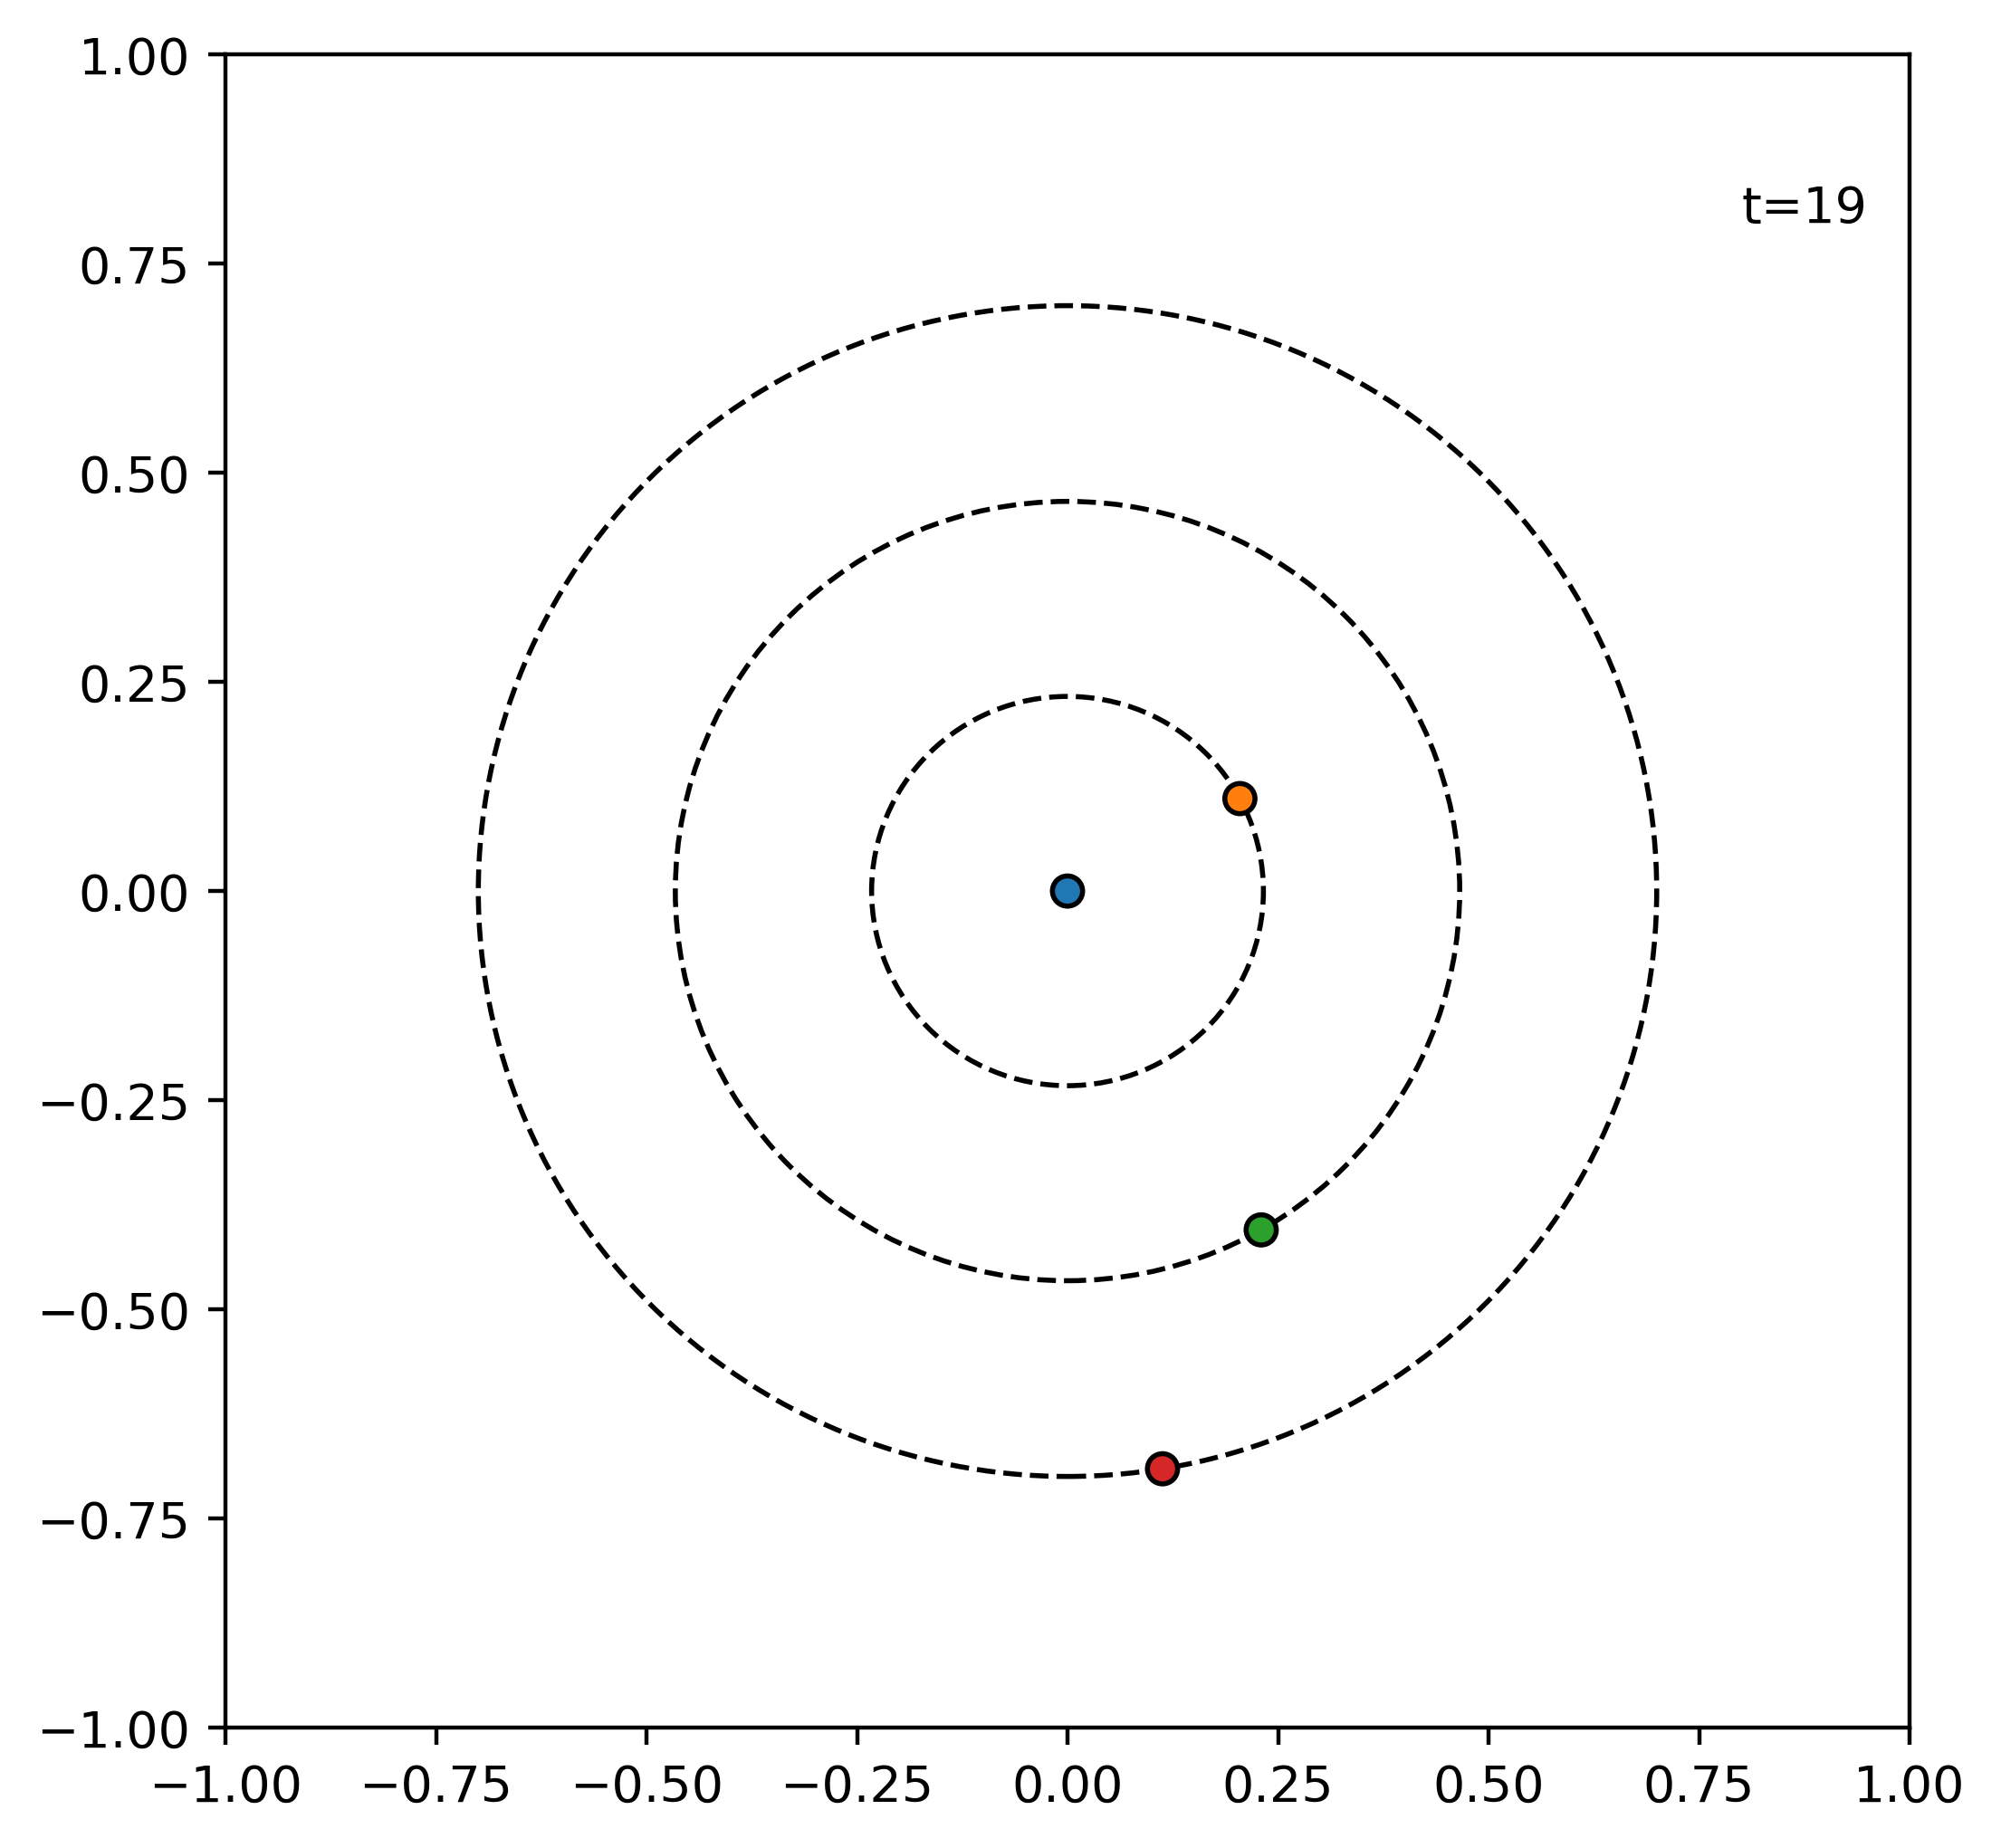

In [6]:
particles = [
    Particle( 0.000,  0.000, +1.0),
    Particle(+0.110, +0.205, +0.3),
    Particle(+0.230, -0.405,  0.0),
    Particle(+0.617, +0.330, -0.1),
]

simulator = ParticleSimulator(particles)
visualize_simulation(simulator, timesteps=20, fps=5, savename='particles-test.gif') # fps = no. time steps per second => 4 second GIF

```{figure} ./benchmarking/particles-test.gif
---
width: 550px
---
```

In [7]:
!pytest hp/tests -vv

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0 -- /Users/particle1331/opt/miniconda3/envs/ai/bin/python3.9
cachedir: .pytest_cache
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331/code/ok-transformer/docs/nb/notes/benchmarking
plugins: anyio-3.6.2, benchmark-4.0.0
collected 1 item                                                               

hp/tests/test_particles.py::test_evolve PASSED                           [100%]

============================== 1 passed in 0.19s ===============================


## Benchmarking

Tests ensure the correctness of our functionality but gives little information about its
running time. A **benchmark** is a simple and representative use case that can be run to
assess the running time of an application. Benchmarks are very useful to keep track of
increase or decrease in execution time with each new iteration during development.

In [8]:
from hp.benchmarks import benchmark, random_particles

random_particles??

Signature: random_particles(n: int) -> list[hp.particles.Particle]
Docstring: <no docstring>
Source:   
def random_particles(n: int) -> list[Particle]:
    particles = []
    for _ in range(n):
        x, y, ω = np.random.random(3)
        particles.append(Particle(x, y, ω))
    return particles
File:      ~/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py
Type:      function

In [9]:
benchmark??

Signature: benchmark()
Docstring: <no docstring>
Source:   
def benchmark():
    particles = random_particles(100)
    simulator = ParticleSimulator(particles)
    simulator.evolve(1.0)
File:      ~/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py
Type:      function

### Timing

For an accurate measurement, the benchmark should have a long
enough execution time (in the order of seconds) so that setup and teardown 
is small compared to the main function. 
Running the benchmark using [`timeit`](https://docs.python.org/3/library/timeit.html):

In [10]:
%timeit benchmark()

3.77 s ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can also simply time using the `time` module. Here using a context makes the code cleaner. This also helps with nested contexts.

In [11]:
import time

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        end = time.time()
        self.elapsed = end - self.start


with Timer() as t:
    benchmark()

print(f"Time elapsed: {t.elapsed:.2f} s")

Time elapsed: 3.85 s


Nested contexts:

In [12]:
with Timer() as t1:
    time.sleep(1)
    with Timer() as t2:
        time.sleep(2)

print(f"{t2.elapsed:.2f} s")
print(f"{t1.elapsed:.2f} s")

2.00 s
3.01 s


### Line profiling

Profiling functions line-by-line can be useful for precisely determining bottlenecks. Note that the `Time` column is based on the `Timer unit` set to `1e-06`. For example, the line that performs random sampling uses the largest chunk of the total execution time shown. 

In [13]:
%load_ext line_profiler
%lprun -f random_particles random_particles(100)

Timer unit: 1e-06 s

Total time: 0.000271 s
File: /Users/particle1331/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py
Function: random_particles at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def random_particles(n: int) -> list[Particle]:
     6         1          0.0      0.0      0.0      particles = []
     7       101         15.0      0.1      5.5      for _ in range(n):
     8       100        181.0      1.8     66.8          x, y, ω = np.random.random(3)
     9       100         74.0      0.7     27.3          particles.append(Particle(x, y, ω))
    10         1          1.0      1.0      0.4      return particles

In [14]:
%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 10.2306 s
File: /Users/particle1331/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py
Function: benchmark at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def benchmark():
    13         1        251.0    251.0      0.0      particles = random_particles(100)
    14         1         11.0     11.0      0.0      simulator = ParticleSimulator(particles)
    15         1   10230350.0 10230350.0    100.0      simulator.evolve(1.0)

Notice that most compute occurs in evolving the system. This makes sense. We will proceed to optimize this part of the code in the next section. Note that [`line_profiler`](https://github.com/pyutils/line_profiler) can be used in the command line using:

```bash
kernprof -l -v script.py
``` 

where the function to profile is decorated with `@profile`.

### Perfplot

There is also [perfplot](https://github.com/nschloe/perfplot) for quickly benchmarking different implementations of the same function. This extends [timeit](https://docs.python.org/3/library/timeit.html) by testing snippets with input parameters and results plotting. Below we compare times of summing a list of integers:

Output()

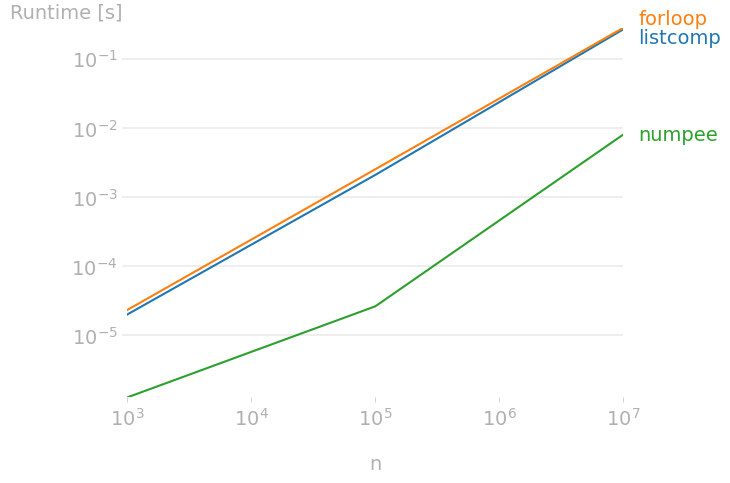

In [15]:
import perfplot
import numpy as np

listcomp = lambda n: sum([i for i in range(n)])
numpee = lambda n: np.arange(n).sum()

def forloop(n):
    s = 0
    for i in range(n):
        s += i
    return s


perfplot.show(
    setup=lambda n: n,  # =: n (kernels input)
    kernels=[listcomp, forloop, numpee],
    labels=["listcomp", "forloop", "numpee"],
    n_range=[1000, 100_000, 10_000_000],
    xlabel="n",
    equality_check=None
)

More optional arguments with their default values:

```python
perfplot.show(
    ...
    
    logx="auto",                        # Set to True or False to force scaling
    logy="auto",
    equality_check=np.allclose,         # Set to None to disable "correctness" assertion
    show_progress=True,
    target_time_per_measurement=1.0,
    max_time=None,                      # Maximum time per measurement
    time_unit="s",                      # Set to one of ("auto", "s", "ms", "us", or "ns")
    relative_to=1,                      # Plot the timings relative to one of the measurements
    flops=lambda n: 3*n                 # FLOPS plots
)
```

## Optimizing our code

Now that we know where the bottleneck to our code is, we can start optimizing this part of the code. To make our code faster, we use **vectorization** using the `numpy` library. This allows us to update the particles in parallel. Note that in the `evolve` method we replace looping on the particles with array operations on the data matrix which stores the data of all particles in the system. Using `np.float64` is important to get precise enough for the tests.

In [16]:
%%writefile ./hp/particles.py
import numpy as np


class Particle:    
    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel


class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles
        self.data = np.array(
            [[p.x, p.y, p.ω] for p in particles], dtype=np.float64)

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""
        n_steps = int(t / self.h)
        for _ in range(n_steps):
            self.update_data()

        for i, p in enumerate(self.particles):
            p.x, p.y = self.data[i, [0, 1]]

    def update_data(self):
        """Evolve particle with Δt = h."""
        x = self.data[:, [0]]
        y = self.data[:, [1]]
        ω = self.data[:, [2]]
        vx = -y * ω
        vy =  x * ω
        dx = vx * self.h
        dy = vy * self.h
        self.data[:, [0]] += dx
        self.data[:, [1]] += dy

Overwriting ./hp/particles.py


Checking the changes:

In [17]:
!git diff hp

diff --git a/docs/nb/notes/benchmarking/hp/particles.py b/docs/nb/notes/benchmarking/hp/particles.py
index 4d827526..2e8dfb3b 100644
--- a/docs/nb/notes/benchmarking/hp/particles.py
+++ b/docs/nb/notes/benchmarking/hp/particles.py
@@ -12,21 +12,26 @@ class ParticleSimulator:
     def __init__(self, particles: list[Particle], h=1e-5):
         self.h = h  # Euler-method increment 
         self.particles = particles
+        self.data = np.array(
+            [[p.x, p.y, p.ω] for p in particles], dtype=np.float64)
 
     def evolve(self, t: float):
         """Evolve system from t=0 to t=t."""
-        
         n_steps = int(t / self.h)
         for _ in range(n_steps):
-            for p in self.particles:
-                self.update_particle(p)
+            self.update_data()
 
-    def update_particle(self, p: Particle):
-        """Evolve particle with Δt = h."""
+        for i, p in enumerate(self.particles):
+            p.x, p.y = self.data[i, [0, 1]]
 
-        vx = -p.y * p.ω

Running the test and benchmarks on the optimized code:

In [18]:
!pytest hp

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331/code/ok-transformer/docs/nb/notes/benchmarking
plugins: anyio-3.6.2, benchmark-4.0.0
collected 1 item                                                               

hp/tests/test_particles.py .                                             [100%]

============================== 1 passed in 0.22s ===============================


Note that the execution time has been reduced by one order of magnitude:

In [19]:
%timeit benchmark()

1.04 s ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 1.16274 s
File: /Users/particle1331/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py
Function: benchmark at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def benchmark():
    13         1        745.0    745.0      0.1      particles = random_particles(100)
    14         1         63.0     63.0      0.0      simulator = ParticleSimulator(particles)
    15         1    1161936.0 1161936.0     99.9      simulator.evolve(1.0)

## Memory profiling

Memory profiling can be useful for data intensive tasks. This can determine inefficiencies with data structures used as well as algorithms used for processing data. As benchmark, we simply increase the number of particles in the simulation:

In [21]:
from hp.benchmarks import benchmark_memory

benchmark_memory??

Signature: benchmark_memory()
Docstring: <no docstring>
Source:   
def benchmark_memory():
    particles = random_particles(1000000)
    simulator = ParticleSimulator(particles)
    simulator.evolve(0.001)
File:      ~/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py
Type:      function

The `Increment` column shows how much each line affects the total memory consumption while `Mem usage` is the cumulative memory use of the function. Note that the function starts out with some background memory consumption from the interpreter and the profiler itself.

In [22]:
%load_ext memory_profiler
%mprun -f benchmark_memory benchmark_memory()

Filename: /Users/particle1331/code/ok-transformer/docs/nb/notes/benchmarking/hp/benchmarks.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    17     85.0 MiB     85.0 MiB           1   def benchmark_memory():
    18    287.2 MiB    202.2 MiB           1       particles = random_particles(1000000)
    19    391.6 MiB    104.4 MiB           1       simulator = ParticleSimulator(particles)
    20    450.4 MiB     58.8 MiB           1       simulator.evolve(0.001)

```{margin}
**1 MiB** = 1,048,576 bytes
```

This shows 10⁶ `Particle` objects take ~260 MiB of memory.

Note [`memory_profiler`](https://github.com/pythonprofilers/memory_profiler) has a command-line interface:

```
mprof run <script.py>
mprof plot
```

This expects a Python script that defines a function of interest decorated with `@profile` imported from the `memory_profiler` module. It should also execute the function, so that the memory profiler tracks something.

**Remark.** To reduce each particle's memory footprint, we can 
use `__slots__` on the `Particle` class.
This saves some memory by avoiding storing the variables of the instance in an internal
dictionary with the small limitation that addition of
attributes other than the ones specified is not allowed. In our example, this saves ~100 MiB.

```python
class Particle:    
    __slots__ = ["x", "y", "ω"]     # <- (!)
    
    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel
```

In [23]:
%%writefile ./hp/particles.py
import numpy as np


class Particle:    
    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel


class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""
        
        n_steps = int(t / self.h)
        for _ in range(n_steps):
            for p in self.particles:
                self.update_particle(p)

    def update_particle(self, p: Particle):
        """Evolve particle with Δt = h."""

        vx = -p.y * p.ω
        vy =  p.x * p.ω
        dx = vx * self.h
        dy = vy * self.h
        p.x += dx
        p.y += dy

Overwriting ./hp/particles.py


---

■